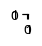

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 150

sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
from datetime import datetime as dt
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import LabelEncoder
import torch
from torch import nn
from torch.nn import functional as F
mpl.rcParams['figure.dpi'] = 180
# Load models together
%load_ext autoreload
%autoreload 2
    
from src.torch_utils import load_model_full
from src.utils import get_class_initcode_keys
from torch.utils.data import SequentialSampler
from src.datasets import *
from src.models import *
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, add_median_labels, get_palette
from src.sim_utils import make_dist_matrix
from src.torch_utils import save_checkpoint, load_checkpoint
from src.train_eval import predict_model, train_eval_loops
from src.models import FullTCRVAE, TwoStageVAECLF
from src.conv_models import CNNVAE, TwoStageCNNVAECLF
from src.metrics import reconstruction_accuracy, compute_cosine_distance
from src.cluster_utils import *
from src.networkx_utils import *

In [2]:
from tqdm.auto import tqdm
from glob import glob
tqdm.pandas()

In [3]:
# For some reasons can't trust the summary files ; redo it here:
def get_summary(output_df):
    summary = []
    for pred_label in sorted(output_df.cluster_label.unique()):
        tmp = output_df.query('cluster_label==@pred_label')
        tmp = tmp.groupby('label').agg(count=('B3','count'))
        tmp['perc'] = tmp['count'] / tmp['count'].sum()
        summary.append({'pred_label':pred_label, 
                        'majority_label':tmp['perc'].idxmax(),
                        'purity':tmp.loc[tmp['perc'].idxmax()]['perc'],
                        'cluster_size':tmp['count'].sum()})
    return pd.DataFrame(summary)
    
def filter_single(seed_number, model_name, purity_threshold=0.75, size_threshold=5):
    out_file = glob(
        f'../output/2503XX_IMMREP25_output/score_vs_healthy/100_seeds_runs/*seed_{seed_number:04}*/*IMMREP25{model_name}_TCRcluster_results*.csv')
    assert (len(out_file) == 1), f'Couldn\'t find files for seed {seed_number}'
    out_df = pd.read_csv(out_file[0])
    sum_df = get_summary(out_df)
    # Check the summaries
    sum_df = sum_df.query('majority_label=="sample" and purity>@purity_threshold and cluster_size>@size_threshold')
    queried_labels = sum_df['pred_label'].unique()
    # Remove the healthy backgrounds from the out_df and take only the matched outputs
    drop_columns = [x for x in out_df.columns if x.startswith('z_') or 'reconstructed' in x]
    out_df = out_df.query('cluster_label in @queried_labels and label=="sample"').drop(columns=drop_columns).assign(
        seed=seed_number)
    return out_df.merge(sum_df[['pred_label', 'purity', 'majority_label', 'cluster_size']], left_on=['cluster_label'], right_on=['pred_label'])

In [4]:
%ls ../output/2503XX_IMMREP25_output/score_vs_healthy/100_seeds_runs/ | head -n 3

seed_0000_ratio_1.0_IMMREP25_Ratio1_Run000_KFold_NoKF_250307_1047_IMMREP25/
seed_0001_ratio_1.0_IMMREP25_Ratio1_Run001_KFold_NoKF_250307_1047_IMMREP25/
seed_0002_ratio_1.0_IMMREP25_Ratio1_Run002_KFold_NoKF_250307_1047_IMMREP25/


In [5]:
%ls ../output/2503XX_IMMREP25_output/score_vs_healthy/100_seeds_runs/seed_0000_ratio_1.0_IMMREP25_Ratio1_Run000_KFold_NoKF_250307_1047_IMMREP25 | grep TS_NOTRP

seed_0000_ratio_1.0_IMMREP25_Ratio1_Run000_KFold_NoKF_250307_1047_IMMREP25TS_NOTRP_TCRcluster_results.csv
seed_0000_ratio_1.0_IMMREP25_Ratio1_Run000_KFold_NoKF_250307_1047_IMMREP25TS_NOTRP_clusters_summary.csv
seed_0000_ratio_1.0_IMMREP25_Ratio1_Run000_KFold_NoKF_250307_1047_IMMREP25TS_NOTRP_complete_cosine_sorted_heatmap.png
seed_0000_ratio_1.0_IMMREP25_Ratio1_Run000_KFold_NoKF_250307_1047_IMMREP25TS_NOTRP_optimisation_curves.png
seed_0000_ratio_1.0_IMMREP25_Ratio1_Run000_KFold_NoKF_250307_1047_IMMREP25TS_NOTRP_optimisation_results_df.csv


In [6]:
raw_df = pd.read_csv('../data/IMMREP25/test.csv_fmt4TCRcluster_uniq').assign(label='sample')
raw_df['index_col']=[f'sample_{i:05}' for i in range(len(raw_df))]
raw_df.head()

,A1,A2,A3,B1,B2,B3,label,index_col
0,ATGYPS,ATKADDK,ALGGSQGNLI,DFQATT,SNEGSKA,SASRYGETDTQY,sample,sample_00000
1,ATGYPS,ATKADDK,ALKVVSNYQLI,DFQATT,SNEGSKA,SARLYFPESGQNYEQY,sample,sample_00001
2,ATGYPS,ATKADDK,ALLFTGGGNKLT,SGDLS,YYNGEE,ASSVGAQSTDTQY,sample,sample_00002
3,ATGYPS,ATKADDK,ALNPTGAGSYQLT,SEHNR,FQNEAQ,ASSSGQGADEQY,sample,sample_00003
4,ATGYPS,ATKADDK,ALQGAQKLV,MGHRA,YSYEKL,ASSQVASGFEGAPPPLH,sample,sample_00004


In [7]:
# --> Create adjacency matrix for entire dataset (undirected)
# --> weight between two nodes = number of times they were found in a cluster > criteria together
# --> keep connection for some X > 100 ? check for clusters in final matrix

In [8]:
def fill_adjacency(df, adj_matrix):
    for label in df.cluster_label.unique():
        tmp = df.query('cluster_label==@label')
        indices = tmp['index_col'].values
        adj_matrix.loc[indices, indices]+=1

def do_single_adj(adj_matrix, seed_number, model_name, purity_threshold=.75, size_threshold=5):
    df = filter_single(seed_number, model_name, purity_threshold, size_threshold)
    fill_adjacency(df, adj_matrix)
    return adj_matrix.values

def get_adj_dist_matrices(raw_df, n_jobs=8):
    # WORKAROUND TO USE PARALLEL to fill adj matrix because otherwise it doesn't update the df
    adj_matrix = pd.DataFrame(columns=raw_df['index_col'].values, index=raw_df['index_col'].values).fillna(0)
    wrapper = partial(do_single_adj, adj_matrix=adj_matrix, model_name='OS_NOTRP', purity_threshold=.75, size_threshold=5)
    adjs = Parallel(n_jobs=8)(delayed(wrapper)(seed_number=s) for s in tqdm(range(100)))
    adj_values = sum([adj for adj in adjs])
    # Fill diag with 100 (adjacency to self is 100 since it's always found with itself)
    np.fill_diagonal(adj_values, 100)
    adj_matrix.loc[adj_matrix.index, adj_matrix.index] = adj_values
    # Get the dist matrix (1 - X and normalise and fill diag with 0s)
    dist_matrix = adj_matrix.copy()
    dm_values = dist_matrix.values
    dm_values = 1 - (dm_values/100) # normalise distance to range (0,1)
    # Distance to self is 0
    np.fill_diagonal(dm_values, 0)
    dist_matrix.loc[dist_matrix.index, dist_matrix.index] = dm_values
    return adj_matrix, dist_matrix

def generate_all(dist_matrix):
    # Get random labels 
    dist_matrix['fake_labels'] = [f'random_label_{i}' for i in np.random.randint(0,5, len(dist_matrix))] 
    dist_array = dist_matrix.iloc[:len(dist_matrix), :len(dist_matrix)].values
    labels = dist_matrix['fake_labels'].values
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)
    return dist_matrix, dist_array, labels, encoded_labels, label_encoder

def rerun_clustering(raw_df, dist_matrix, threshold=None, pval_threshold=0.05):
    # convoluted cause I can't be bothered to rethink this it takes 1ms to compute
    threshold_pval_dict = {(100-i)/100:binom_test(i, 100) for i in range(50, 100)}
    pval_threshold_dict = {v:k for k,v in threshold_pval_dict.items()}
    pv_thresholds = pd.DataFrame({v:k for k,v in threshold_pval_dict.items()}, index=['dist']).T.reset_index().rename(columns={'index':'pv'})
    
    dist_matrix, dist_array, labels, encoded_labels, label_encoder = generate_all(dist_matrix)
    # manual threshold overrides pval threshold
    if threshold is None:
        threshold = pv_thresholds.query('pv<@pval_threshold').iloc[0]['dist']
    metrics, clusters_df, c = agglo_single_threshold(dist_array, dist_array, labels, encoded_labels,
                                                 label_encoder, threshold,
                                                 return_df_and_c=True)
    # Remerge to input df
    dist_matrix.drop(columns=['fake_labels'], inplace=True)
    dist_matrix['pred_label'] = c.labels_
    merged_output = pd.merge(raw_df.set_index('index_col'), dist_matrix['pred_label'], left_index=True, right_index=True)
    
    merged_output = merged_output.merge(merged_output.groupby(['pred_label']).agg(cluster_size=('B3','count')).reset_index(),
                        left_on=['pred_label'], right_on=['pred_label'])
    merged_output['cluster_threshold'] = threshold
    return merged_output

  0%|          | 0/100 [00:00<?, ?it/s]

<Axes: >

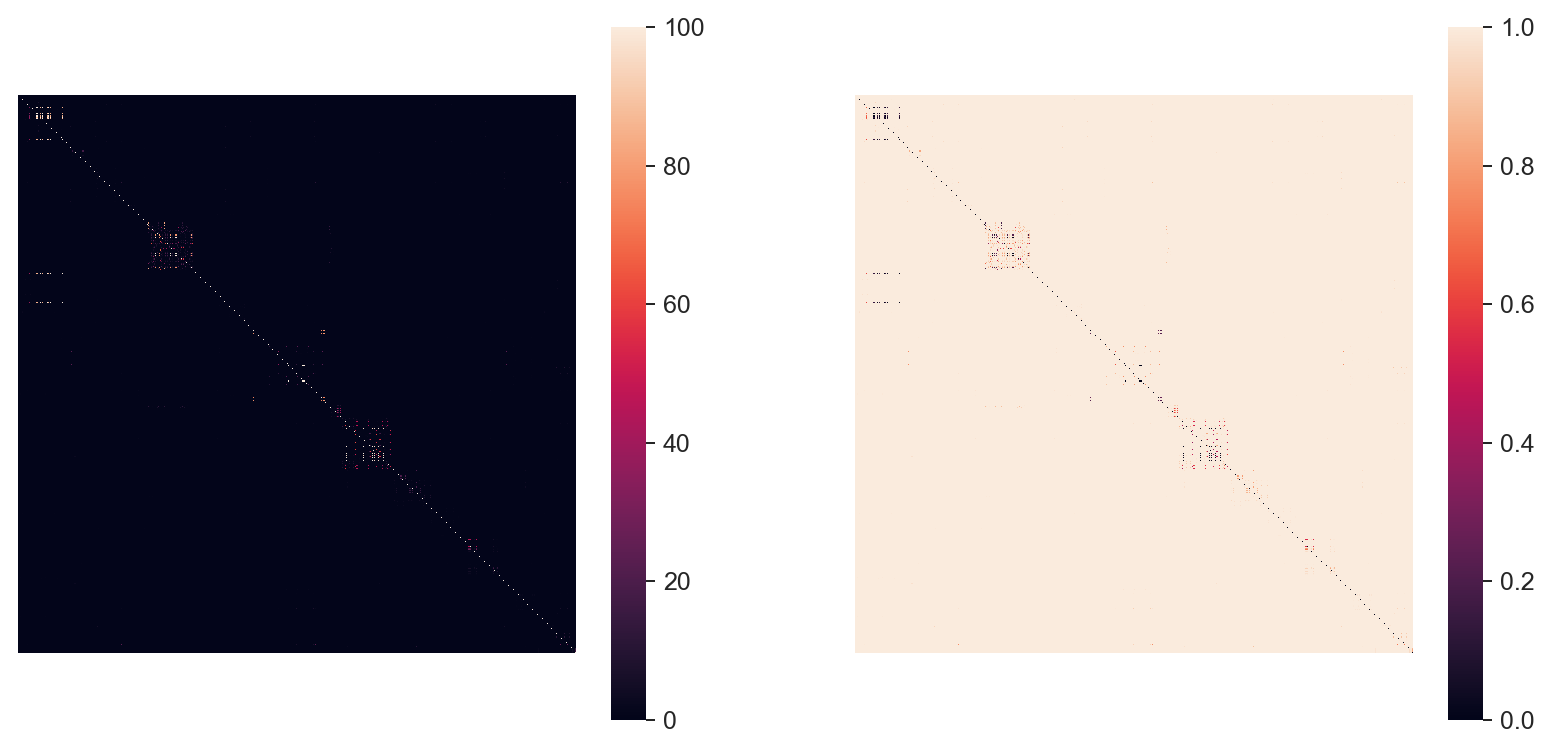

In [11]:
# Convert to distance matrix to use in agglomerative clustering
adj_matrix, dist_matrix = get_adj_dist_matrices(raw_df, -1)
# check heatmap
fig, ax = plt.subplots(1,2, figsize=(11, 5))
sns.heatmap(adj_matrix, xticklabels=False, yticklabels=False, square=True, ax=ax[0])
sns.heatmap(dist_matrix, xticklabels=False, yticklabels=False ,square=True, ax=ax[1])

In [53]:
binom_test(100-39,100)

0.03520020021770477

In [79]:
wtf = rerun_clustering(raw_df, dist_matrix, None, 0.05)
wtf

,A1,A2,A3,B1,B2,B3,label,pred_label,cluster_size,cluster_threshold
0,ATGYPS,ATKADDK,ALGGSQGNLI,DFQATT,SNEGSKA,SASRYGETDTQY,sample,628,1,0.39
1,ATGYPS,ATKADDK,ALKVVSNYQLI,DFQATT,SNEGSKA,SARLYFPESGQNYEQY,sample,827,1,0.39
2,ATGYPS,ATKADDK,ALLFTGGGNKLT,SGDLS,YYNGEE,ASSVGAQSTDTQY,sample,627,1,0.39
3,ATGYPS,ATKADDK,ALNPTGAGSYQLT,SEHNR,FQNEAQ,ASSSGQGADEQY,sample,626,1,0.39
4,ATGYPS,ATKADDK,ALQGAQKLV,MGHRA,YSYEKL,ASSQVASGFEGAPPPLH,sample,700,1,0.39
...,...,...,...,...,...,...,...,...,...,...
995,YSGSPE,HISR,ALSGLSWGKLQ,MNHEY,SMNVEV,ASSVAGDSYNEQF,sample,8,1,0.39
996,YSGSPE,HISR,ALSGSGAGSYQLT,SEHNR,FQNEAQ,ASSLGFGGPTYEQY,sample,3,1,0.39
997,YSGSPE,HISR,ALSPPTDSWGKLQ,MNHEY,SMNVEV,ASSLAGDSYNEQF,sample,30,1,0.39
998,YSGSPE,HISR,ALTGSGAGSYQLT,SEHNR,FQNEAQ,ASSLGDRGLDTQY,sample,52,1,0.39


In [84]:
wtf.query('cluster_size>7')

,A1,A2,A3,B1,B2,B3,label,pred_label,cluster_size,cluster_threshold
23,DRGSQS,IYSNGD,ALRTGNQFY,SGDLS,YYNGEE,ASSAPGDEQY,sample,12,15,0.39
24,DRGSQS,IYSNGD,AVKESNDYKLS,SGDLS,YYNGEE,ASSAQGDEQY,sample,12,15,0.39
25,DRGSQS,IYSNGD,AVKGAGNMLT,SGDLS,YYNGEE,ASSPPGDEQF,sample,12,15,0.39
26,DRGSQS,IYSNGD,AVKLADMR,SGDLS,YYNGEE,ASSPPGDTQY,sample,12,15,0.39
27,DRGSQS,IYSNGD,AVKPGSARQLT,SGDLS,YYNGEE,ASSPPGDEQY,sample,12,15,0.39
28,DRGSQS,IYSNGD,AVKPPFQGAQKLV,SGDLS,YYNGEE,ASSNMGNIQY,sample,12,15,0.39
29,DRGSQS,IYSNGD,AVKRGISGGYNKLI,SGDLS,YYNGEE,ASSAPGDEQF,sample,12,15,0.39
30,DRGSQS,IYSNGD,AVKTGGSQGNLI,SGDLS,YYNGEE,ASSAPGNEQF,sample,12,15,0.39
31,DRGSQS,IYSNGD,AVNIGIQGAQKLV,SGDLS,YYNGEE,ASSPSGGEQY,sample,12,15,0.39
32,DRGSQS,IYSNGD,AVNLGNQGGKLI,SGDLS,YYNGEE,ASSPPGNEQF,sample,12,15,0.39


In [83]:
wtf.merge(wtf.groupby('pred_label').agg(xd=('B3','count')).reset_index(),
          left_on=['pred_label'], right_on=['pred_label']).query('pred_label==4')

,A1,A2,A3,B1,B2,B3,label,pred_label,cluster_size,cluster_threshold,xd
231,NIATNDY,GYKTK,LAGNTGNQFY,SGHRS,YFSETQ,ASSPVADNEQF,sample,4,7,0.39,7
232,NIATNDY,GYKTK,LGAGSYQLT,SGHRS,YFSETQ,ASSPTASTEAF,sample,4,7,0.39,7
233,NIATNDY,GYKTK,LGYSGAGSYQLT,SGHRS,YFSETQ,ASSPTASYEQY,sample,4,7,0.39,7
234,NIATNDY,GYKTK,LHTGGFKTI,SGHRS,YFSETQ,ASTSTTSYEQY,sample,4,7,0.39,7
235,NIATNDY,GYKTK,LVAPTGNQFY,SGHRS,YFSETQ,ASSPIARGPNTGELF,sample,4,7,0.39,7
236,NIATNDY,GYKTK,LVGDPRQLT,SGHRS,YFSETQ,ASTPVAKNIQY,sample,4,7,0.39,7
237,NIATNDY,GYKTK,LVHGVPKII,SGHRS,YFSETQ,ASSLGGNQPQH,sample,4,7,0.39,7


In [145]:
df=pd.read_csv('../output/2503XX_IMMREP25_output/score_vs_healthy/100_seeds_analysis/TS_NOTRP/rerun_cluster_TS_NOTRP_pv_0.70.csv')
df.groupby(['pred_label']).agg(count=('B3','count')).query('count!=1').sort_values('count',ascending=False)['count'].cumsum()

pred_label
43      13
10      26
89      38
9       48
20      57
103     66
47      75
207     82
40      89
39      96
21     102
11     108
3      114
7      120
2      125
24     130
19     135
0      138
51     141
25     144
26     147
5      150
44     153
12     155
4      157
23     159
1      161
8      163
Name: count, dtype: int64

<Axes: >

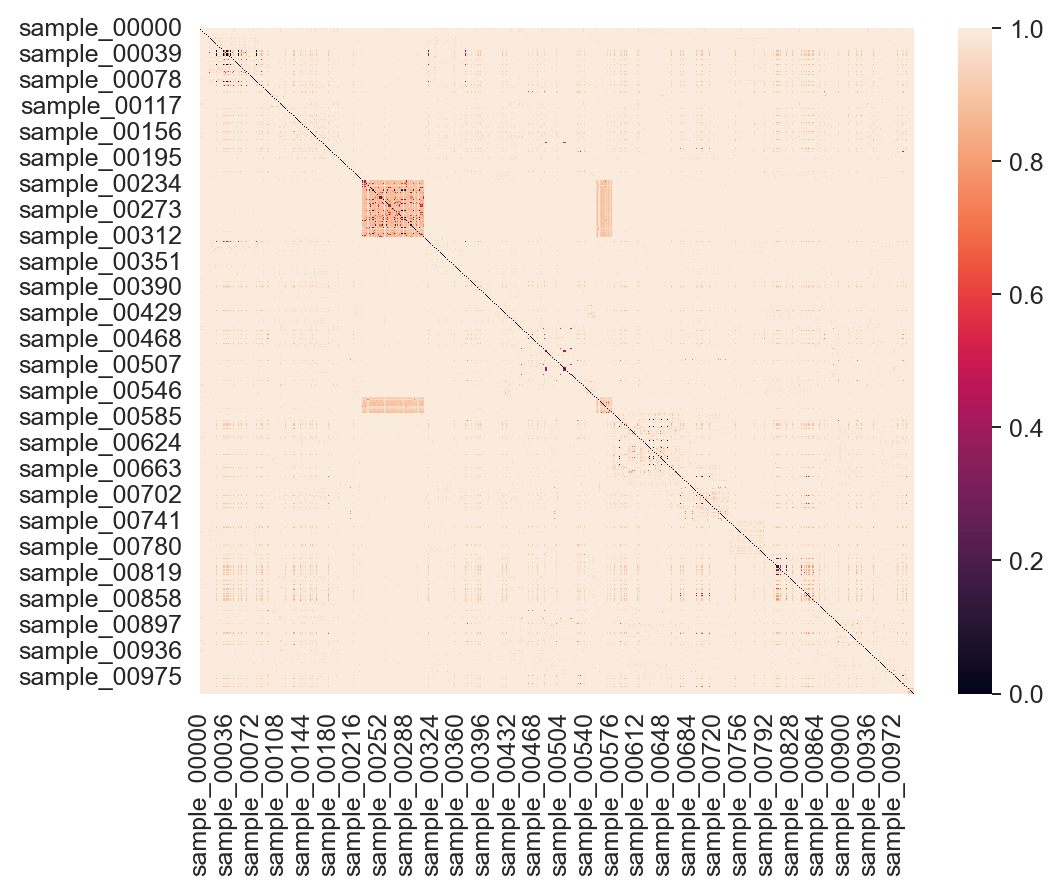

In [136]:
a = pd.read_csv('../output/2503XX_IMMREP25_output/score_vs_healthy/100_seeds_analysis/TS_NOTRP/TS_NOTRP_100runs_normed_distance_matrix.csv', 
               header=[0], index_col=[0])
sns.heatmap(a)

In [72]:
pd.read_csv('../output/2503XX_IMMREP25_output/webserver/TwoStage_NoTriplet/TS_NT_TCRcluster_results.csv').groupby(['cluster_label']).agg(cluster_size=('B3','count'),xd=('A3','count')).groupby('cluster_size').count()

,xd
cluster_size,
1,65
2,184
3,88
4,34
5,21
6,1
7,3
8,2
9,1


In [74]:
9*18

162

In [89]:
pd.read_csv('../output/2503XX_IMMREP25_output/score_vs_healthy/rerun_cluster_TS_NOTRP_pv_0.650000.csv').groupby('cluster_size').count()

,Unnamed: 0,A1,A2,A3,B1,B2,B3,pred_label,cluster_threshold
cluster_size,,,,,,,,,
1,858,858,858,858,858,858,858,858,858
2,6,6,6,6,6,6,6,6,6
3,15,15,15,15,15,15,15,15,15
4,4,4,4,4,4,4,4,4,4
5,25,25,25,25,25,25,25,25,25
6,12,12,12,12,12,12,12,12,12
7,21,21,21,21,21,21,21,21,21
8,16,16,16,16,16,16,16,16,16
9,18,18,18,18,18,18,18,18,18


In [127]:
fpr<=0.1

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,